In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 


In [21]:
from pycaret.datasets import get_data
import pandas as pd

dataset=pd.read_csv('MIMIC3_preprocessed.csv')
dataset.shape



(39289, 5)

In [22]:
from pandas_profiling import ProfileReport
prof = ProfileReport(dataset)
prof.to_file(output_file='diabetes_MIMIC3.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ProfileReport(dataset)

In [11]:
# Percentage of Diabetes case in dataset
y=dataset['diabetic/non-diabetic']
percent_pos = sum(y)/len(y)
print('MIMIC3 Percentage Diabetes cases %.02f %% (%.02f %%)' %(percent_pos * 100, (1-percent_pos) * 100.))

MIMIC3 Percentage Diabetes cases 22.49 % (77.51 %)


In [12]:
print('MIMIC Percentage Diabetes cases  %d %.02f%%  %d  %.02f%% ' % 
      (sum(y) , percent_pos * 100,  len(y) - sum(y), (1-percent_pos)*100 ))

MIMIC Percentage Diabetes cases  8838 22.49%  30451  77.51% 


In [23]:
#data = dataset.sample(frac=0.90, random_state=786).reset_index(drop=True)
#data_unseen = dataset.drop(data.index).reset_index(drop=True)

#print('Data for Modeling: ' + str(data.shape))
#print('Unseen Data For Predictions: ' + str(data_unseen.shape))
data = dataset

### Generic Data preparation function

In [16]:
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

def mimic_data_prep(df = None, do_balance = False):
    X = df.drop(["diabetic/non-diabetic"], axis = 1)
    y = df["diabetic/non-diabetic"]

    le = LabelEncoder()
    X['ETHNICITY'] = le.fit_transform(X['ETHNICITY'])
    if 'GENDER' in X.columns:
        X['GENDER'] = le.fit_transform(X['GENDER'])
        
    if do_balance:
        # transform the dataset
        oversample = SMOTE(random_state=123)
        X, y = oversample.fit_resample(X, y)     
        
    # SCALING
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 123)

    return X, y ,X_train, X_test, y_train, y_test

In [17]:
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
data_analysis = dataset

le = LabelEncoder()
data_analysis['ETHNICITY'] = le.fit_transform(data_analysis['ETHNICITY'])
if 'GENDER' in data_analysis.columns:
    data_analysis['GENDER'] = le.fit_transform(data_analysis['GENDER'])

In [18]:
corr=data_analysis
corr

,ETHNICITY,GENDER,Age,FamilyHistory,diabetic/non-diabetic
0,33,0,40,0,1
1,33,1,46,0,0
2,33,1,81,0,0
3,13,0,27,0,0
4,33,0,0,0,0
...,...,...,...,...,...
39284,21,1,71,0,1
39285,33,1,50,0,0
39286,33,1,66,0,0
39287,33,0,89,0,1


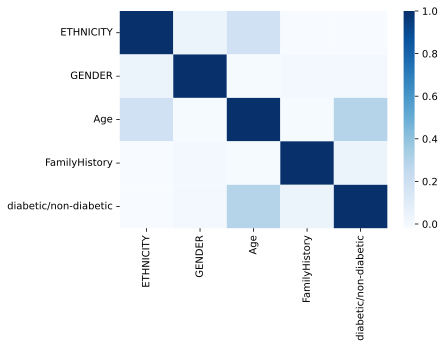

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = data_analysis.corr()
sns.heatmap(corr,annot = False, cmap='Blues')

plt.savefig("Figure9c.png", format = 'png', dpi=1200,  bbox_inches='tight')

## Data def  for feature selection

In [24]:
data.columns

Index(['ETHNICITY', 'GENDER', 'Age', 'FamilyHistory', 'diabetic/non-diabetic'], dtype='object')

In [25]:
# Removefeatures
df_fs = data.drop(["GENDER", "FamilyHistory"], axis = 1)

# Hyperparameters

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve

## Functions

In [27]:
from sklearn.linear_model import LogisticRegression
def tune_lr(X_train, y_train):
    lr_params = {"solver": ['lbfgs','newton-cg','liblinear','sag','saga'],
              "C" : [2**-6, 2**-4, 2**-2, 1, 2**2, 2**4, 2**6],
              # "max_iter" : [200,300,400,500,600,700,800,900,1000,2000,3000]
             "max_iter" : [200]
            }
    lr_model = LogisticRegression(random_state=123)
    lr_cv_model = GridSearchCV(lr_model, lr_params,  cv = 10,  n_jobs = -1, verbose = 2) 

    grid_result = lr_cv_model.fit(X_train, y_train)

    return grid_result

In [28]:
from sklearn.svm import SVC
def tune_svm(X_train,y_train):
    svm_params = {"kernel": ['linear'],
              "C" : [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "max_iter" : [1000,3000],
            #"gamma" : [2**-6, 2**-4, 2**-2, 1, 2**2]
            }
    svm_model = SVC(random_state=123)
    svm_cv_model = GridSearchCV(svm_model, svm_params, cv = 10, n_jobs = -1, verbose = 2) 

    grid_result = svm_cv_model.fit(X_train, y_train)
    return grid_result

In [29]:
from sklearn.ensemble import RandomForestClassifier
def tune_rf(X_train, y_train):
    rf_params = {"max_depth": [None,2,5,8],
                 "criterion": ['gini','entropy'],
                "max_features": [None,'sqrt','log2'],
                #"n_estimators": [10, 20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
                 "n_estimators": [10, 20, 40, 60, 80, 100, 200, 300, 400, 500, 600]
                }

    rf_model = RandomForestClassifier(random_state=123)
    rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1, verbose = 2) 
    grid_result = rf_cv_model.fit(X_train, y_train)
    return grid_result

In [30]:
def test_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print('accuracy score', accuracy_score(y_test, y_pred))
    print('cross_val_score', cross_val_score(model, x_test, y_test, cv = 10).mean())

In [31]:
def print_grid_result(title, grid_result):
    print('####', title, '####')
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_)

# Function to evaluate model

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
import time

def test_model2(model,X,y, verbose=False, n_splits=10):
    acc = 0
    auc = 0
    f1 = 0
    prec = 0
    recall = 0
    
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=123)
    
    start_time = time.time()
    for train_index, test_index in sss.split(X, y):
        if X is pd.DataFrame:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
          
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc1 = accuracy_score(y_test, y_pred)
        auc1 = roc_auc_score(y_test, y_pred, average="macro")
        f11 = f1_score(y_test, y_pred, average="macro")
        prec1 = precision_score(y_test, y_pred, average="macro")
        recall1 = recall_score(y_test, y_pred, average="macro")
        if verbose:
            print ('acc', acc1)
            print('f1', f11)
            print('recall1', recall1)
            print('auc1', auc1)
        acc += acc1
        auc += auc1
        f1 += f11
        prec += prec1
        recall += recall1
        
    spent_time = time.time() - start_time
    print("Acc      F-Meas   Precis   Recall   AUC      Time")
    print("%.04f\t%.04f\t%.04f\t%.04f\t%.04f\t%0.4f" % (acc/n_splits, f1/n_splits, prec/n_splits, 
                                            recall/n_splits, auc/n_splits, spent_time))
    

### Display a confusion matrix

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def disp_conf_matrix(title, cm):
    #ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    ax = sns.heatmap(cm, fmt='d', annot=True, cmap='Blues')

    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Non-Diab','Diab'])
    ax.yaxis.set_ticklabels(['Non-Diab','Diab'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [34]:
def calculate_confusion_matrices(models, X_test, y_test):
    cms = []
    for mod in models:
        y_pred = mod.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)
    return cms

## Display a row of confusion matrices

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def disp_conf_matrices(main_title, titles, cms):
 
    num = len(cms)
    fig, axes = plt.subplots(1,num,figsize=(10, 3), constrained_layout=True)    
    
    fig.suptitle(main_title);
    for i in range(len(cms)):    
        sns.heatmap(cms[i], fmt='d', annot=True, cmap='Blues', ax=axes[i])
        axes[i].set_title(titles[i],fontsize=10);
        axes[i].set_xlabel('\nPredicted Values',fontsize=8)
        axes[i].set_ylabel('Actual Values',fontsize=8);

        ## Ticket labels - List must be in alphabetical order
        axes[i].xaxis.set_ticklabels(['Non-Diab','Diab'])
        axes[i].yaxis.set_ticklabels(['Non-Diab','Diab'])
    plt.savefig(main_title + '.png', format='png',  bbox_inches='tight', dpi=1200)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

## Data preparation NO FS NO BL

### Hyper param tuning LR

In [36]:
X,y, X_train, X_test, y_train, y_test  = mimic_data_prep(dataset, do_balance=False)

In [105]:
lr_result = tune_lr(X_train, y_train)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   22.5s finished


In [106]:
print_grid_result('LR ', lr_result)


#### LR  ####
Best Score:  0.774889131225009
Best Params:  {'C': 0.015625, 'max_iter': 200, 'solver': 'lbfgs'}


### Hyper param tuning SVM

In [60]:
svm_result = tune_svm(X_train, y_train)


Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  1.2min finished
D:\alain\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [36]:
print_grid_result('SVM ', svm_result)


#### SVM  ####
Best Score:  0.605158018571759
Best Params:  {'C': 0.01, 'kernel': 'linear', 'max_iter': 1000}


### Hyper param  tuning RF

In [37]:
rf_result = tune_rf(X_train, y_train)

Fitting 10 folds for each of 264 candidates, totalling 2640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed: 10.9min finished


In [38]:
print_grid_result('RF ', rf_result)

#### RF  ####
Best Score:  0.7793978652390867
Best Params:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}


In [37]:
lr_tuned_nofs_nobl = LogisticRegression(C = 0.015625, solver = 'lbfgs', max_iter = 200, random_state=123)
svm_tuned_nofs_nobl = SVC(C = 0.01, kernel = 'linear', max_iter = 1000, random_state=123)
rf_tuned_nofs_nobl = RandomForestClassifier(max_depth = None,  max_features = 'sqrt', 
                    criterion = 'entropy', n_estimators = 300, random_state=123)
rf_tuned_other = RandomForestClassifier(max_depth = None,  max_features = 'log2', 
                    criterion = 'entropy', n_estimators = 50, random_state=123)

In [38]:
test_model2(rf_tuned_other, X,y,verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7720	0.5153	0.6277	0.5330	0.5330	20.1073


In [39]:
test_model2(lr_tuned_nofs_nobl, X,y,verbose=False)
test_model2(svm_tuned_nofs_nobl, X,y,verbose=False)
test_model2(rf_tuned_nofs_nobl, X,y,verbose=False)
#test_model2(rf_tuned_other, X,y,verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7747	0.4383	0.5476	0.5004	0.5004	3.6752


C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

Acc      F-Meas   Precis   Recall   AUC      Time
0.4537	0.4405	0.5499	0.5665	0.5665	23.1940
Acc      F-Meas   Precis   Recall   AUC      Time
0.7721	0.5146	0.6279	0.5326	0.5326	110.8996


### confusion matrices No FS - NoBL

In [40]:
(cm_lr_nofs_nobl, cm_svm_nofs_nobl, cm_rf_nofs_nobl) = calculate_confusion_matrices(
    [lr_tuned_nofs_nobl, svm_tuned_nofs_nobl, rf_tuned_nofs_nobl], X_test, y_test)

# Do Feature selection

In [41]:
X,y, X_train, X_test, y_train, y_test  = mimic_data_prep(df_fs, do_balance=False)

### LR

In [62]:
lr_result = tune_lr(X_train, y_train)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 335 out of 350 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    2.2s finished


In [63]:
print_grid_result('LR ', lr_result)

#### LR  ####
Best Score:  0.7746709494068272
Best Params:  {'C': 0.015625, 'max_iter': 200, 'solver': 'lbfgs'}


In [64]:
svm_result = tune_svm(X_train, y_train)


Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:   52.8s finished
D:\alain\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [65]:
print_grid_result('SVM ', svm_result)

#### SVM  ####
Best Score:  0.5972246786292588
Best Params:  {'C': 0.001, 'kernel': 'linear', 'max_iter': 3000}


In [46]:
rf_result = tune_rf(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 264 candidates, totalling 2640 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed:  9.6min finished


In [47]:
print_grid_result('RF ', rf_result)

#### RF  ####
Best Score:  0.778525164403027
Best Params:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'n_estimators': 400}


In [42]:
# Create tuned model for LR
lr_tuned_fs_nobl = LogisticRegression(C = 0.015625, solver = 'lbfgs', max_iter = 200, random_state=123)
# Create tuned model for SVM
svm_tuned_fs_nobl = SVC(C = 0.001, kernel = 'linear', max_iter = 3000, random_state=123)

# Create tuned model for RF
rf_tuned_fs_nobl = RandomForestClassifier(max_depth = 5,  max_features = None, 
                        criterion = 'entropy', n_estimators = 400, random_state=123)
#rf_tuned_other = RandomForestClassifier(max_depth = None,  max_features = None, 
#                        criterion = 'entropy', n_estimators = 50, random_state=123)

In [43]:
test_model2(lr_tuned_fs_nobl, X,y,verbose=False)
test_model2(svm_tuned_fs_nobl, X,y,verbose=False)
test_model2(rf_tuned_fs_nobl, X,y,verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7747	0.4381	0.5416	0.5003	0.5003	2.2360


C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScale

Acc      F-Meas   Precis   Recall   AUC      Time
0.4511	0.4269	0.5378	0.5545	0.5545	64.0358
Acc      F-Meas   Precis   Recall   AUC      Time
0.7775	0.5141	0.6595	0.5341	0.5341	93.7574


### Confusion marices: FS - no BL

In [44]:
(cm_lr_fs_nobl, cm_svm_fs_nobl, cm_rf_fs_nobl) = calculate_confusion_matrices(
    [lr_tuned_fs_nobl, svm_tuned_fs_nobl, rf_tuned_fs_nobl], X_test, y_test)

# Feature Selection and Balancing

In [45]:
# Use Feature selection data_frame df_fs
X,y, X_train, X_test, y_train, y_test  = mimic_data_prep(df_fs, do_balance=True)

### LR

In [74]:
lr_result = tune_lr(X_train, y_train)


Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 335 out of 350 | elapsed:    6.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    6.3s finished


In [75]:
print_grid_result('LR ', lr_result)

#### LR  ####
Best Score:  0.6532103269592756
Best Params:  {'C': 0.015625, 'max_iter': 200, 'solver': 'liblinear'}


In [76]:
## SVM
svm_result = tune_svm(X_train, y_train)
print_grid_result('SVM ', svm_result)
## RF
rf_result = tune_rf(X_train, y_train)
print_grid_result('RF ', rf_result)

Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  2.2min finished
D:\alain\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#### SVM  ####
Best Score:  0.639698654903509
Best Params:  {'C': 0.01, 'kernel': 'linear', 'max_iter': 3000}
Fitting 10 folds for each of 264 candidates, totalling 2640 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed: 15.2min finished


#### RF  ####
Best Score:  0.6651734524436675
Best Params:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'n_estimators': 40}


In [46]:
lr_tuned_fs_bl = LogisticRegression(C =  0.015625, solver = 'liblinear', max_iter = 200, random_state=123)
svm_tuned_fs_bl = SVC(C = 0.01, kernel = 'linear', max_iter = 3000, random_state=123)
rf_tuned_fs_bl = RandomForestClassifier(max_depth = None,  max_features = None, 
                    criterion = 'gini', n_estimators = 40, random_state=123)
#rf_tuned = RandomForestClassifier(max_depth = None,  max_features = None, 
#                    criterion = 'entropy', n_estimators = 50, random_state=123)

In [47]:
test_model2(lr_tuned_fs_bl, X,y,verbose=False)
test_model2(svm_tuned_fs_bl, X,y,verbose=False)
test_model2(rf_tuned_fs_bl, X,y, verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.6508	0.6477	0.6564	0.6508	0.6508	1.9468


C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScale

Acc      F-Meas   Precis   Recall   AUC      Time
0.6062	0.5582	0.6277	0.6062	0.6062	93.6559
Acc      F-Meas   Precis   Recall   AUC      Time
0.6651	0.6509	0.6969	0.6651	0.6651	22.7652


### Confusion marices: FS - BL

In [48]:
(cm_lr_fs_bl, cm_svm_fs_bl, cm_rf_fs_bl) = calculate_confusion_matrices(
    [lr_tuned_fs_bl, svm_tuned_fs_bl, rf_tuned_fs_bl], X_test, y_test)

# Prepare data: Balancing without FS

In [49]:
# Use Feature selection data_frame df_fs
X,y, X_train, X_test, y_train, y_test  = mimic_data_prep(data, do_balance=True)

In [88]:
lr_result = tune_lr(X_train, y_train)
print_grid_result('LR ', lr_result)

svm_result = tune_svm(X_train, y_train)
print_grid_result('SVM ', svm_result)

rf_result_nofs_bl = tune_rf(X_train, y_train)

print_grid_result('RF ', rf_result_nofs_bl)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#### LR  ####
Best Score:  0.6539140237190819
Best Params:  {'C': 0.015625, 'max_iter': 200, 'solver': 'liblinear'}
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:  3.1min finished
D:\alain\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#### SVM  ####
Best Score:  0.642114876292757
Best Params:  {'C': 0.1, 'kernel': 'linear', 'max_iter': 3000}
Fitting 10 folds for each of 264 candidates, totalling 2640 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2640 out of 2640 | elapsed: 15.9min finished


#### RF  ####
Best Score:  0.6663696610170238
Best Params:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 80}


In [50]:
lr_tuned_nofs_bl = LogisticRegression(C = 0.015625, solver = 'liblinear', max_iter = 200, random_state=123)
svm_tuned_nofs_bl = SVC(C = 0.01, kernel = 'linear', max_iter = 300, random_state=123)
rf_tuned_nofs_bl = RandomForestClassifier(max_depth = None,  max_features = None, 
                        criterion = 'entropy', n_estimators = 80, random_state=123)
#rf_tuned = RandomForestClassifier(max_depth = None,  max_features = 'sqrt', 
#                        criterion = 'entropy', n_estimators = 50, random_state=123)

In [51]:
test_model2(lr_tuned_nofs_bl, X,y,verbose=False)
test_model2(svm_tuned_nofs_bl, X,y,verbose=False)
test_model2(rf_tuned_nofs_bl, X,y,verbose=False)
#test_model2(rf_tuned, X,y,verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.6507	0.6471	0.6571	0.6507	0.6507	2.4804


C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\alain\.conda\envs\tf2\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

Acc      F-Meas   Precis   Recall   AUC      Time
0.6334	0.6051	0.6818	0.6334	0.6334	12.2423
Acc      F-Meas   Precis   Recall   AUC      Time
0.6656	0.6549	0.6892	0.6656	0.6656	58.6831


### Confusion matrices: no FS- BLb

In [52]:
(cm_lr_nofs_bl, cm_svm_nofs_bl, cm_rf_nofs_bl) = calculate_confusion_matrices(
    [lr_tuned_nofs_bl, svm_tuned_nofs_bl, rf_tuned_nofs_bl], X_test, y_test)

# Compare confusion matrices

In [53]:
titles = ['No Feature Selec. No Balancing\n','No Feature Selec. Balancing\n','Feature Selec. Balancing\n' ]

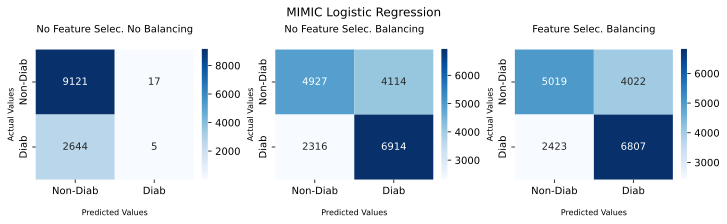

In [54]:
disp_conf_matrices('MIMIC Logistic Regression', titles, 
                   [cm_lr_nofs_nobl, cm_lr_nofs_bl, cm_lr_fs_bl])

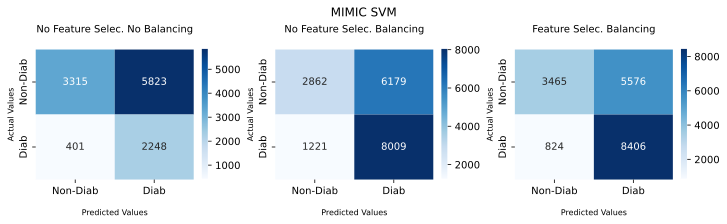

In [55]:
disp_conf_matrices('MIMIC SVM', titles, 
                   [cm_svm_nofs_nobl, cm_svm_nofs_bl, cm_svm_fs_bl])

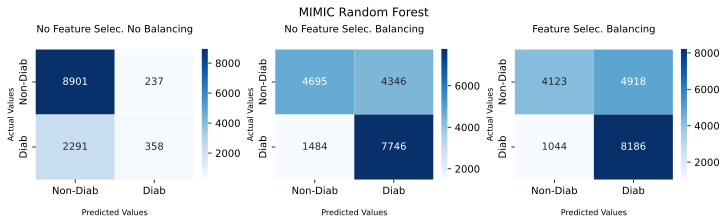

In [56]:
disp_conf_matrices('MIMIC Random Forest', titles, 
                   [cm_rf_nofs_nobl, cm_rf_nofs_bl, cm_rf_fs_bl])

# Tuning and 3 plot

In [28]:
from sklearn.model_selection import GridSearchCV
import numpy as np
max_features_range = np.arange(1,3,1)
n_estimators_range = np.arange(10,200,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)
rf = RandomForestClassifier()
grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:   51.1s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [34]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'max_features': 1, 'n_estimators': 30} with a score of 0.77


In [35]:
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

,max_features,n_estimators,Accuracy
0,1,10,0.773107
1,1,20,0.774271
2,1,30,0.774780
3,1,40,0.773580
4,1,50,0.773544


In [36]:
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()
grid_contour

Accuracy
max_features n_estimators          
1            10            0.773107
             20            0.774271
             30            0.774780
             40            0.773580
             50            0.773544
             60            0.773616
             70            0.774489
             80            0.773762
             90            0.774198
             100           0.773980
             110           0.774016
             120           0.773689
             130           0.773980
             140           0.774234
             150           0.774671
             160           0.774380
             170           0.774162
             180           0.773362
             190           0.773980
2            10            0.773435
             20            0.773362
             30            0.773835
             40            0.773944
             50            0.774271
             60            0.774053
             70            0.773653
             80            0.773834
             90            0.773726
             100           0.773944
             110           0.773835
             120           0.774271
             130           0.773689
             140           0.773689
             150           0.774489
             160           0.774344
             170           0.774380
             180           0.774089
             190           0.774089

In [37]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot('max_features', 'n_estimators')
grid_pivot

Accuracy                                                    \
n_estimators       10        20        30        40        50        60    
max_features                                                               
1             0.773107  0.774271  0.774780  0.773580  0.773544  0.773616   
2             0.773435  0.773362  0.773835  0.773944  0.774271  0.774053   

                                                                          \
n_estimators       70        80        90        100       110       120   
max_features                                                               
1             0.774489  0.773762  0.774198  0.773980  0.774016  0.773689   
2             0.773653  0.773834  0.773726  0.773944  0.773835  0.774271   

                                                                          \
n_estimators       130       140       150       160       170       180   
max_features                                                               
1             0.773980  0.774234  0.774671  0.774380  0.774162  0.773362   
2             0.773689  0.773689  0.774489  0.774344  0.774380  0.774089   

                        
n_estimators       190  
max_features            
1             0.773980  
2             0.774089

In [ ]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values
import plotly.graph_objects as go
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features') 
            ) )
fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )
fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [49]:
import plotly.graph_objects as go
fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=True,
                  width=800, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [50]:
from pycaret.classification import *

In [51]:
diab=setup(data = data, target = 'diabetic/non-diabetic', session_id=123) 

,Description,Value
0,session_id,123
1,Target,diabetic/non-diabetic
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(39289, 5)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7770,0.7193,0.0712,0.5424,0.1258,0.0778,0.1326,0.3860
ada,Ada Boost Classifier,0.7761,0.7168,0.0633,0.5280,0.1129,0.0684,0.1208,0.1510
lightgbm,Light Gradient Boosting Machine,0.7745,0.7140,0.0682,0.5032,0.1200,0.0698,0.1177,0.1020
ridge,Ridge Classifier,0.7742,0.0000,0.0032,0.5638,0.0064,0.0033,0.0249,0.0250
xgboost,Extreme Gradient Boosting,0.7739,0.7136,0.0714,0.4934,0.1246,0.0717,0.1176,0.5920
catboost,CatBoost Classifier,0.7737,0.7151,0.0714,0.4896,0.1246,0.0712,0.1164,1.9650
lr,Logistic Regression,0.7733,0.6988,0.0454,0.4730,0.0828,0.0453,0.0882,0.4200
lda,Linear Discriminant Analysis,0.7722,0.6982,0.0325,0.4340,0.0605,0.0302,0.0655,0.0620
dt,Decision Tree Classifier,0.7712,0.6925,0.0767,0.4581,0.1312,0.0712,0.1101,0.0380
et,Extra Trees Classifier,0.7709,0.6955,0.0772,0.4548,0.1318,0.0711,0.1093,0.2390


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [52]:
compare_models(include=['lr','svm','rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7750,0.7071,0.0540,0.4959,0.0972,0.0559,0.1029,2.2700
rf,Random Forest Classifier,0.7736,0.7045,0.1060,0.4866,0.1740,0.1016,0.1421,0.2680
svm,SVM - Linear Kernel,0.5513,0.0000,0.7413,0.2851,0.3768,0.1440,0.2272,0.2680


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
dataset.columns

Index(['ETHNICITY', 'GENDER', 'Age', 'Diabetes'], dtype='object')

In [13]:
rf=create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7721,0.6826,0.1002,0.4697,0.1651,0.0934,0.1315
1,0.7735,0.6992,0.0969,0.4839,0.1615,0.0934,0.1347
2,0.7691,0.7031,0.1052,0.4422,0.1699,0.0915,0.1238
3,0.7735,0.7053,0.1050,0.4851,0.1726,0.1006,0.1409
4,0.7793,0.7054,0.1195,0.5441,0.1960,0.1251,0.1742
5,0.7669,0.7025,0.0921,0.4191,0.1510,0.0761,0.1060
6,0.7727,0.7172,0.1034,0.4776,0.1700,0.0977,0.1368
7,0.7789,0.7094,0.1099,0.5440,0.1828,0.1159,0.1666
8,0.7749,0.7068,0.1195,0.5000,0.1930,0.1162,0.1570


In [14]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

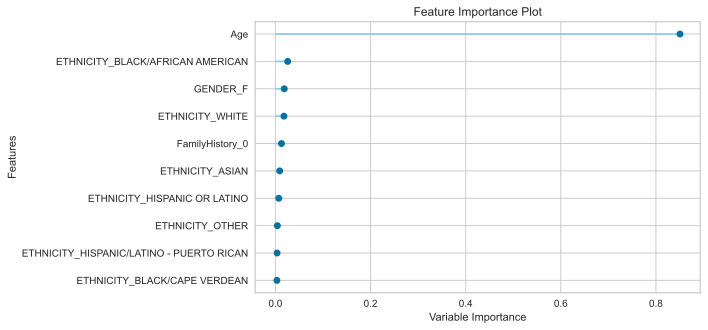

In [39]:
plot_model(rf, plot='feature')

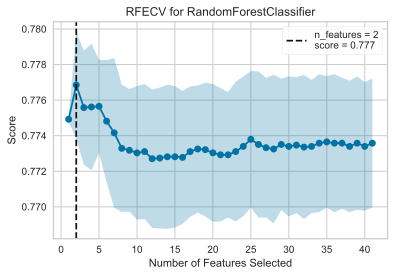

In [40]:
plot_model(rf, plot='rfe')

# SETUP with feature selection

In [7]:
diab=setup(data = data, target = 'diabetic/non-diabetic', session_id=123, 
           feature_selection=True, feature_selection_threshold = 0.5) 

,Description,Value
0,session_id,123
1,Target,diabetic/non-diabetic
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(39289, 5)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [8]:
get_config('prep_pipe').named_steps["feature_select"].selected_columns_test

Index(['ETHNICITY_HISPANIC/LATINO - PUERTO RICAN', 'ETHNICITY_ASIAN',
       'ETHNICITY_MIDDLE EASTERN', 'GENDER_F',
       'ETHNICITY_HISPANIC/LATINO - COLOMBIAN',
       'ETHNICITY_WHITE - OTHER EUROPEAN', 'ETHNICITY_BLACK/HAITIAN',
       'ETHNICITY_ASIAN - KOREAN', 'ETHNICITY_WHITE',
       'ETHNICITY_ASIAN - CHINESE',
       'ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'ETHNICITY_HISPANIC OR LATINO', 'ETHNICITY_WHITE - EASTERN EUROPEAN',
       'FamilyHistory_0', 'ETHNICITY_BLACK/AFRICAN', 'ETHNICITY_PORTUGUESE',
       'Age', 'ETHNICITY_HISPANIC/LATINO - GUATEMALAN', 'ETHNICITY_OTHER',
       'ETHNICITY_ASIAN - ASIAN INDIAN', 'ETHNICITY_MULTI RACE ETHNICITY',
       'ETHNICITY_HISPANIC/LATINO - DOMINICAN', 'ETHNICITY_WHITE - RUSSIAN',
       'ETHNICITY_BLACK/CAPE VERDEAN', 'ETHNICITY_BLACK/AFRICAN AMERICAN',
       'ETHNICITY_HISPANIC/LATINO - CUBAN', 'ETHNICITY_WHITE - BRAZILIAN',
       'ETHNICITY_ASIAN - VIETNAMESE', 'ETHNICITY_ASIAN - FILIPINO'],
      dtype

In [9]:
len(get_config('prep_pipe').named_steps["feature_select"].selected_columns_test)

29

In [28]:
get_config('X_train').columns

Index(['Age', 'ETHNICITY_ASIAN - VIETNAMESE',
       'ETHNICITY_WHITE - OTHER EUROPEAN', 'ETHNICITY_WHITE - RUSSIAN',
       'ETHNICITY_ASIAN', 'ETHNICITY_ASIAN - FILIPINO',
       'ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'ETHNICITY_HISPANIC/LATINO - CUBAN',
       'ETHNICITY_WHITE - EASTERN EUROPEAN', 'ETHNICITY_ASIAN - CHINESE',
       'ETHNICITY_HISPANIC OR LATINO', 'ETHNICITY_PORTUGUESE',
       'ETHNICITY_WHITE - BRAZILIAN', 'GENDER_F', 'FamilyHistory_0',
       'ETHNICITY_WHITE', 'ETHNICITY_MULTI RACE ETHNICITY',
       'ETHNICITY_HISPANIC/LATINO - COLOMBIAN', 'ETHNICITY_OTHER',
       'ETHNICITY_BLACK/AFRICAN', 'ETHNICITY_HISPANIC/LATINO - GUATEMALAN',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_ASIAN - ASIAN INDIAN',
       'ETHNICITY_BLACK/CAPE VERDEAN',
       'ETHNICITY_HISPANIC/LATINO - PUERTO RICAN', 'ETHNICITY_ASIAN - KOREAN',
       'ETHNICITY_HISPANIC/LATINO - DOMINICAN', 'ETHNICITY_BLACK/HAITIAN',
       'ETHNICITY_MIDDLE EASTERN'],
    

In [ ]:
plot_model(rf,'feature')

In [29]:
compare_models(include=['lr','svm','rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7750,0.7072,0.0541,0.4962,0.0974,0.0561,0.1031,0.2280
rf,Random Forest Classifier,0.7735,0.7040,0.1068,0.4864,0.1751,0.1023,0.1426,0.2430
svm,SVM - Linear Kernel,0.6592,0.0000,0.4099,0.2770,0.2300,0.0974,0.1561,0.2370


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Remove Age column

In [18]:
data_feature_select = data.drop('GENDER', axis=1)

In [19]:
diab=setup(data = data_feature_select, target = 'Diabetes', session_id=123) 

,Description,Value
0,session_id,123
1,Target,Diabetes
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(39289, 3)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
compare_models(include=['lr','svm','rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7727,0.6984,0.0445,0.4571,0.0809,0.0431,0.0832,0.4260
rf,Random Forest Classifier,0.7719,0.7050,0.0849,0.4707,0.1437,0.0804,0.1206,0.2420
svm,SVM - Linear Kernel,0.7169,0.0000,0.2090,0.1647,0.1253,0.0549,0.0859,0.2960


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Fix imbalance SMOTE

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN

In [19]:
diab=setup(data = data, target = 'Diabetes', session_id=123, 
           feature_selection=False, feature_selection_threshold = 0.5,
           fix_imbalance=True )


,Description,Value
0,session_id,123
1,Target,Diabetes
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(39289, 4)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
compare_models(include=['lr','svm','rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.6167,0.0000,0.5200,0.1815,0.2636,0.0985,0.1534,0.5070
lr,Logistic Regression,0.5997,0.6966,0.7399,0.3284,0.4549,0.2070,0.2499,0.6220
rf,Random Forest Classifier,0.5702,0.6932,0.7630,0.3140,0.4448,0.1839,0.2328,0.5220


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
rbfsvm=create_model('rbfsvm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5314,0.6665,0.8824,0.3107,0.4595,0.1886,0.2716
1,0.5365,0.6800,0.8776,0.3125,0.4609,0.1918,0.2731
2,0.5360,0.6744,0.8887,0.3134,0.4634,0.1951,0.2802
3,0.5418,0.6955,0.8887,0.3163,0.4666,0.2008,0.2858
4,0.5415,0.6798,0.8855,0.3157,0.4655,0.1993,0.2832
5,0.5382,0.6690,0.8758,0.3128,0.4610,0.1927,0.2735
6,0.5655,0.7056,0.9002,0.3304,0.4834,0.2285,0.3162
7,0.5527,0.6847,0.8905,0.3224,0.4735,0.2123,0.2975
8,0.5491,0.6854,0.8921,0.3208,0.4719,0.2092,0.2951
9,0.5396,0.6671,0.8776,0.3141,0.4626,0.1949,0.2761


In [116]:
rf 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [119]:
rf=create_model('rf', n_estimators=190, max_features=1 )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7699,0.6948,0.0886,0.4508,0.1480,0.0798,0.1160
1,0.7674,0.6986,0.0902,0.4275,0.1489,0.0763,0.1079
2,0.7705,0.6888,0.0871,0.4538,0.1461,0.0793,0.1162
3,0.7702,0.7073,0.1081,0.4589,0.1749,0.0974,0.1323
4,0.7716,0.7040,0.0903,0.4667,0.1514,0.0844,0.1233
5,0.7665,0.6892,0.0742,0.4035,0.1253,0.0595,0.0886
6,0.7702,0.7079,0.0853,0.4530,0.1436,0.0776,0.1145
7,0.7705,0.7072,0.0950,0.4609,0.1575,0.0871,0.1242
8,0.7665,0.7032,0.0886,0.4198,0.1463,0.0734,0.1038
9,0.7749,0.6980,0.0918,0.5089,0.1555,0.0929,0.1395


In [86]:
svm=create_model('svm', alpha=0.001, class_weight =  {1: 0.5, 0: 0.5}, eta0 = 1, 
                 learning_rate='optimal', loss='hinge', penalty= 'elasticnet')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5296,0.0000,0.8792,0.3093,0.4577,0.1857,0.2676
1,0.4762,0.0000,0.9662,0.2970,0.4544,0.1666,0.2835
2,0.4476,0.0000,0.9871,0.2883,0.4462,0.1494,0.2766
3,0.4702,0.0000,0.9597,0.2935,0.4496,0.1593,0.2728
4,0.4731,0.0000,0.9710,0.2961,0.4538,0.1655,0.2847
5,0.5964,0.0000,0.7597,0.3289,0.4591,0.2107,0.2581
6,0.4778,0.0000,0.9710,0.2984,0.4565,0.1696,0.2889
7,0.5960,0.0000,0.7729,0.3310,0.4635,0.2155,0.2658
8,0.7578,0.0000,0.1498,0.4026,0.2183,0.1092,0.1280
9,0.7287,0.0000,0.2448,0.3543,0.2895,0.1288,0.1321


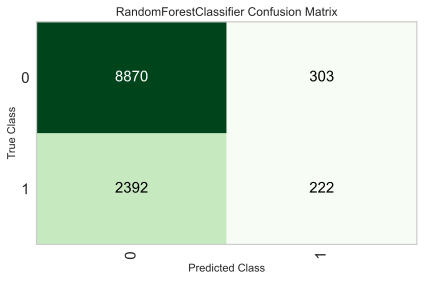

In [120]:
plot_model(rf, plot = 'confusion_matrix')

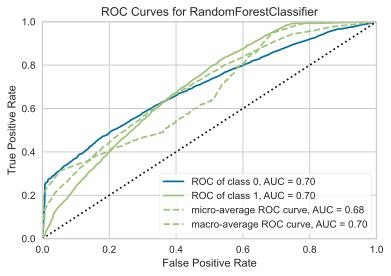

In [25]:
plot_model(rf, plot = 'auc')

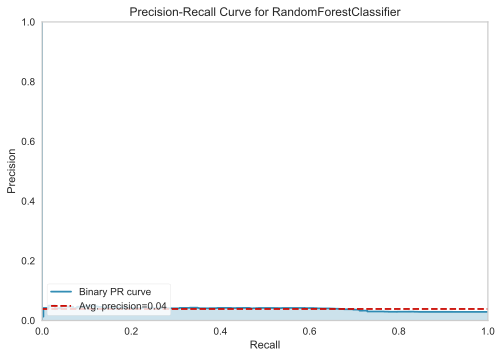

In [18]:
plot_model(rf, plot = 'pr')

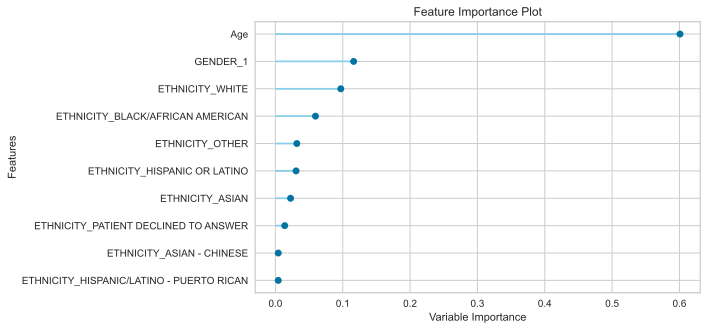

In [19]:
plot_model(rf, plot='feature')


In [40]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [30]:
unseen_predictions = predict_model(gbc, data=data_unseen)
unseen_predictions.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
0,3,130,78,23,79,28.4,0.323,34,1,0,0.6580
1,8,120,86,0,0,28.4,0.259,22,1,1,0.5673
2,2,174,88,37,120,44.5,0.646,24,1,1,0.9184
3,2,106,56,27,165,29.0,0.426,22,0,0,0.9514
4,2,105,75,0,0,23.3,0.560,53,0,0,0.8629


In [31]:
# train now on complete dataset : finalize
final_class = finalize_model(gbc)

In [121]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Feature Selection and Balancing

In [38]:
diab=setup(data = data, target = 'Diabetes', session_id=123, 
           feature_selection=True, feature_selection_threshold = 0.5,
           fix_imbalance=True )


,Description,Value
0,session_id,123
1,Target,Diabetes
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(39289, 4)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
compare_models(include=['lr','svm','rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5996,0.6968,0.7407,0.3284,0.4550,0.2071,0.2502,0.7290
svm,SVM - Linear Kernel,0.5939,0.0000,0.5726,0.1771,0.2702,0.0967,0.1645,0.4560
rf,Random Forest Classifier,0.5703,0.6938,0.7635,0.3141,0.4450,0.1842,0.2332,0.4600


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)